# What Happens When You Predict on an Unseen Categorical Level
i.e. a rare event appears in your test set, which wasn't present in your training set.
___

> *This notebook walks through the steps of importing, cleaning, training, and testing on a data set where the test set contains a categorical level that was not present in the training set. You need to run steps 2. - 6. (to load all the variables) before you can jump between sections and run individual cells*

## Table of Contents
0. [Jump to The Short Answer](#question)
1. [Import, Visualize & Clean Data](#start)
2. [Split into Train and Test Sets](#split) 
3. [Build Models for GLM, GBM, DRF, Deep Learning & Naive Bayes](#build)
4. [Model Performance for GLM, GBM, DRF, Deep Learning & Naive Bayes](#output)
5. [How Each Algorithm Handles Missing Values/New Categorical Levels During Prediction](#answer)
6. [Additional Resources](#resources)

<a name="start"></a>
## Import Packages, Initialize an H2O Cluster & Load Data

In [1]:
import h2o, pandas, pprint, operator, numpy as np, matplotlib.pyplot as plt
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from tabulate import tabulate

In [2]:
# Set 'interactive = True' for interactive plots, 'interactive = False' if not:
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)

In [3]:
# Connect to a cluster 
h2o.init()

H2O cluster uptime:,2 days 23 hours 47 minutes 21 seconds 729 milliseconds
H2O cluster version:,3.6.0.8
H2O cluster name:,H2O_started_from_python
H2O cluster total nodes:,1
H2O cluster total memory:,1.78 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


In [4]:
# 1 - Load data - One row per flight.  
# Columns include origin, destination, departure & arrival times, carrier information, and whether flight was delayed.
print("Import and Parse airlines data")
# air_path = 'allyears2k_headers.zip'
air_path = 'https://github.com/h2oai/h2o-2/raw/master/smalldata/airlines/allyears2k_headers.zip'
data = h2o.import_file(path = air_path)
# data.describe() # uncomment to see summary of loaded data file
# data.head()     # uncomment to see top of the loaded data file

Import and Parse airlines data

Parse Progress: [##################################################] 100%


## Explore Data with Visualizations


glm Model Build Progress: [##################################################] 100%


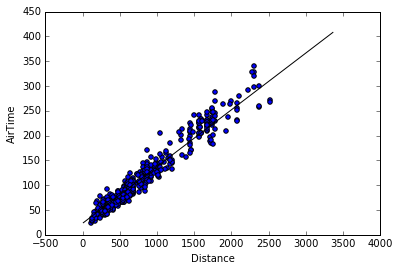

In [5]:
# 2 - Data exploration and munging. 
# Generate scatter plots of various columns and plot fitted GLM model.

# Function to fit a GLM model and plot the fitted (x,y) values
def scatter_plot(data, x, y, max_points = 1000, fit = True):
    if(fit):
        lr = H2OGeneralizedLinearEstimator(family = "gaussian")
        lr.train(x=x, y=y, training_frame=data)
        coeff = lr.coef()
    df = data[[x,y]]
    runif = df[y].runif()
    df_subset = df[runif < float(max_points)/data.nrow]
    df_py = h2o.as_list(df_subset)
    
    if(fit): h2o.remove(lr._id)

    # If x variable is string, generate box-and-whisker plot
    if(df_py[x].dtype == "object"):
        if interactive: df_py.boxplot(column = y, by = x)
    # Otherwise, generate a scatter plot
    else:
        if interactive: df_py.plot(x = x, y = y, kind = "scatter")
    
    if(fit):
        x_min = min(df_py[x])
        x_max = max(df_py[x])
        y_min = coeff["Intercept"] + coeff[x]*x_min
        y_max = coeff["Intercept"] + coeff[x]*x_max
        plt.plot([x_min, x_max], [y_min, y_max], "k-")
    if interactive: plt.show()
        
# generate matplotlib plots inside of ipython notebook        
%matplotlib inline  
scatter_plot(data, "Distance", "AirTime", fit = True)

In [6]:
# Group flights by month
grouped = data.group_by("Month")
bpd = grouped.count().sum("Cancelled").frame
bpd.show()
bpd.describe()
bpd.dim

# Convert columns to factors
data["Year"]= data["Year"].asfactor()
data["Month"] = data["Month"].asfactor()
data["DayOfWeek"] = data["DayOfWeek"].asfactor()
data["Cancelled"] = data["Cancelled"].asfactor()

Month,sum_Cancelled,nrow_Year
1,1067,41979
10,19,1999


Rows:2 Cols:3

Chunk compression summary:


chunk_type,chunk_name,count,count_percentage,size,size_percentage
C1N,1-Byte Integers (w/o NAs),1,33.333336,70 B,30.434782
C2,2-Byte Integers,1,33.333336,72 B,31.304348
C2S,2-Byte Fractions,1,33.333336,88 B,38.260868



Frame distribution summary:


,size,number_of_rows,number_of_chunks_per_column,number_of_chunks
127.0.0.1:54321,230 B,2.0,1.0,3.0
mean,230 B,2.0,1.0,3.0
min,230 B,2.0,1.0,3.0
max,230 B,2.0,1.0,3.0
stddev,0 B,0.0,0.0,0.0
total,230 B,2.0,1.0,3.0


,Month,sum_Cancelled,nrow_Year
type,int,int,int
mins,1.0,19.0,1999.0
mean,5.5,543.0,21989.0
maxs,10.0,1067.0,41979.0
sigma,6.36396103068,741.047906684,28270.1291118
zeros,0,0,0
missing,0,0,0
0,1.0,1067.0,41979.0
1,10.0,19.0,1999.0



Parse Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%


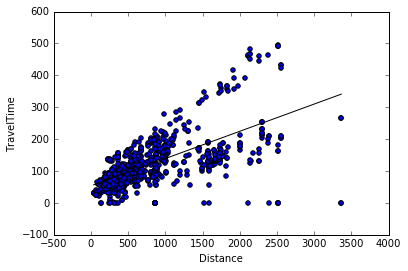

In [7]:
# Calculate and plot travel time
hour1 = data["CRSArrTime"] / 100
mins1 = data["CRSArrTime"] % 100
arrTime = hour1*60 + mins1

hour2 = data["CRSDepTime"] / 100
mins2 = data["CRSDepTime"] % 100
depTime = hour2*60 + mins2

# TODO: Replace this once list comprehension is supported. See PUBDEV-1286.
# data["TravelTime"] = [x if x > 0 else None for x in (arrTime - depTime)]
# data["TravelTime"] = (arrTime-depTime > 0).ifelse((arrTime-depTime), h2o.H2OFrame([[None]] * data.nrow))
# line above doesn't work because it produces a column-wise list instead of a row-wise list
empty_array = np.empty((1,data.nrow,))
empty_array[:]=np.NAN
empty = np.ndarray.tolist(empty_array)
data["TravelTime"] = (arrTime-depTime > 0).ifelse((arrTime-depTime), h2o.H2OFrame(empty))
scatter_plot(data, "Distance", "TravelTime")


glm Model Build Progress: [##################################################] 100%


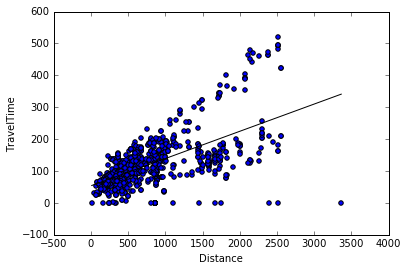

In [8]:
# Impute missing travel times and re-plot
data.impute(column = "Distance", by = ["Origin", "Dest"])
scatter_plot(data, "Distance", "TravelTime")

<a name="split"></a>
# Split Data Set into Train and Test Sets 

In [9]:
# 3 - Fit a model on train; using test as validation.
# Create test/train split
s = data["Year"].runif()
train = data[s <= 0.75]
test  = data[s > 0.75]

In [10]:
# Replace all instances of 'SFO' in the destination column ('Dest') with 'BB8'
test["Dest"] = (test["Dest"] == 'SFO').ifelse('BB8', test["Dest"])
# print out the number of rows that were effected
test[test['Dest']=='BB8'].shape 

(340, 32)

>*We replace all instances of 'SFO' from the 'Dest' column, to create the situation in which your test set has a categorical level that was not present in the training set (Note: all models will run without breaking, because new categorical levels are interpreted as if they were NA values)*

<a name="build"></a>
# Build Models with Supervised Learning Algorithms 

Train models for GLM, GBM, DRF, Deep Learning & Naive Bayes in one go! 

In [11]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with GLM
data_glm = H2OGeneralizedLinearEstimator(family="binomial", standardize=True)
data_glm.train(x = myX, y = myY, training_frame = train, validation_frame = test)

# Predict delays with GBM
data_gbm2 = H2OGradientBoostingEstimator(balance_classes = True, ntrees = 50, max_depth = 5,
                                         distribution = "bernoulli", learn_rate = 0.1, min_rows = 2)
data_gbm2.train(x = myX, y = myY, training_frame = train, validation_frame = test)

# Predict delays with Distributed Random Forest (DRF)
data_rf2 = H2ORandomForestEstimator(ntrees = 10,max_depth = 5, balance_classes = True)
data_rf2.train(x = myX, y = myY, training_frame = train, validation_frame = test)

# Predict delays with Deep Learning
data_dl = H2ODeepLearningEstimator(hidden = [10,10], epochs = 5, variable_importances = True,
                                   balance_classes = True, loss = "Automatic")
data_dl.train(x = myX, y = myY, training_frame = train, validation_frame=test)

# Predict delays with Naive Bayes
# If laplace smoothing is disabled ('laplace=0') the algorithm will predict 0
data_nb = H2ONaiveBayesEstimator(laplace=1) 
data_nb.train(x = myX, y = myY, training_frame = train, validation_frame=test)



glm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

naivebayes Model Build Progress: [##################################################] 100%


### Or build models individually 

<a name="GLM Model"></a>
`Build GLM` 

In [ ]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with GLM
data_glm = H2OGeneralizedLinearEstimator(family="binomial", standardize=True)
data_glm.train(x = myX, y = myY, training_frame = train, validation_frame = test)

data_glm.model_performance(test)

In [12]:
glm_pred_output = data_glm.predict(test)
glm_pred_output.head()

predict,NO,YES
YES,0.486924,0.513076
YES,0.445544,0.554456
YES,0.505696,0.494304
YES,0.445544,0.554456
YES,0.505696,0.494304
YES,0.36161,0.63839
YES,0.36525,0.63475
YES,0.393395,0.606605
YES,0.337481,0.662519
YES,0.393395,0.606605


<a name="GBM Model"></a>
`Build GBM`

In [ ]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with GBM
data_gbm2 = H2OGradientBoostingEstimator(balance_classes = True, ntrees = 50, max_depth = 5,
                                         distribution = "bernoulli", learn_rate = 0.1, min_rows = 2)
data_gbm2.train(x = myX, y = myY, training_frame = train, validation_frame = test)

data_gbm2.model_performance(test)

In [13]:
data_gbm2.predict(test)

predict,NO,YES
NO,0.733556,0.266444
YES,0.627461,0.372539
NO,0.78123,0.21877
YES,0.627461,0.372539
NO,0.78123,0.21877
YES,0.332099,0.667901
YES,0.250787,0.749213
YES,0.286167,0.713833
YES,0.22208,0.77792
YES,0.286167,0.713833


<a name="DRF Model"></a>
`Build Distributed Random Forest`

In [ ]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with Distributed Random Forest (DRF)
data_rf2 = H2ORandomForestEstimator(ntrees = 10,max_depth = 5, balance_classes = True)
data_rf2.train(x = myX, y = myY, training_frame = train, validation_frame = test)

data_rf2.model_performance(test)

In [14]:
data_rf2.predict(test)

predict,NO,YES
YES,0.417667,0.582333
YES,0.353056,0.646944
YES,0.417667,0.582333
YES,0.353056,0.646944
YES,0.417667,0.582333
YES,0.333562,0.666438
YES,0.333562,0.666438
YES,0.333562,0.666438
YES,0.332691,0.667309
YES,0.333562,0.666438


<a name="DL Model"></a>
`Build Deep Learning`

In [ ]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with Deep Learning
data_dl = H2ODeepLearningEstimator(hidden = [10,10], epochs = 5, variable_importances = True,
                                   balance_classes = True, loss = "Automatic")
data_dl.train(x = myX, y = myY, training_frame = train, validation_frame=test)

data_dl.model_performance(test)

In [15]:
data_dl.predict(test)

predict,NO,YES
YES,0.412259,0.587741
YES,0.305322,0.694678
YES,0.395405,0.604595
YES,0.305322,0.694678
YES,0.395405,0.604595
YES,0.340752,0.659248
YES,0.369242,0.630758
YES,0.356076,0.643924
YES,0.31166,0.68834
YES,0.356076,0.643924


<a name="NB Model"></a>
`Build Naive Bayes`

In [ ]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with Naive Bayes
# If laplace smoothing is disabled ('laplace=0') the algorithm will predict 0
data_nb = H2ONaiveBayesEstimator(laplace=1) 
data_nb.train(x = myX, y = myY, training_frame = train, validation_frame=test)

data_nb.model_performance(test)

In [16]:
data_nb.predict(test)

predict,NO,YES
YES,0.454398,0.545602
YES,0.322786,0.677214
YES,0.440799,0.559201
YES,0.322786,0.677214
YES,0.440799,0.559201
YES,0.40981,0.59019
YES,0.408858,0.591142
YES,0.439846,0.560154
YES,0.321941,0.678059
YES,0.439846,0.560154


<a name="output"></a>
## Model Performance and Output 

Run each cell below to see each model's performance on the test set

In [18]:
# GLM performance
data_glm.model_performance(test)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.213916317948
R^2: 0.142562197727
LogLoss: 0.616813724741
Null degrees of freedom: 11018
Residual degrees of freedom: 10758
Null deviance: 15253.1945167
Residual deviance: 13593.3408658
AIC: 14115.3408658
AUC: 0.718386634817
Gini: 0.436773269633

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.389054132:


,NO,YES,Error,Rate
NO,2163.0,3096.0,0.5887,(3096.0/5259.0)
YES,872.0,4888.0,0.1514,(872.0/5760.0)
Total,3035.0,7984.0,0.3601,(3968.0/11019.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3890541,0.7112922,285.0
max f2,0.1035543,0.8461923,392.0
max f0point5,0.5269380,0.6817852,208.0
max accuracy,0.4998685,0.6683910,223.0
max precision,0.9808563,1.0,0.0
max absolute_MCC,0.4998685,0.3346923,223.0
max min_per_class_accuracy,0.5192804,0.6647569,212.0


In [19]:
# Distributed Random Forest Performance
data_rf2.model_performance(test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.216555216936
R^2: 0.131988645599
LogLoss: 0.622661149806
AUC: 0.714823231051
Gini: 0.429646462101

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.428971130131:


,NO,YES,Error,Rate
NO,2115.0,3150.0,0.5983,(3150.0/5265.0)
YES,875.0,4891.0,0.1518,(875.0/5766.0)
Total,2990.0,8041.0,0.3649,(4025.0/11031.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4289711,0.7084812,291.0
max f2,0.2548082,0.8465406,390.0
max f0point5,0.5803026,0.6803653,183.0
max accuracy,0.5248351,0.6615901,222.0
max precision,0.8891400,1.0,0.0
max absolute_MCC,0.5803026,0.3253950,183.0
max min_per_class_accuracy,0.5333499,0.6567811,216.0


In [20]:
# GBM Performance
data_gbm2.model_performance(test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.209125456554
R^2: 0.161769116665
LogLoss: 0.605956064406
AUC: 0.73209342911
Gini: 0.464186858221

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.354493215374:


,NO,YES,Error,Rate
NO,2055.0,3210.0,0.6097,(3210.0/5265.0)
YES,760.0,5006.0,0.1318,(760.0/5766.0)
Total,2815.0,8216.0,0.3599,(3970.0/11031.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3544932,0.7160635,296.0
max f2,0.1794351,0.8462016,375.0
max f0point5,0.5506738,0.6953031,187.0
max accuracy,0.4821806,0.6760946,224.0
max precision,0.9651422,1.0,0.0
max absolute_MCC,0.5110109,0.3525654,208.0
max min_per_class_accuracy,0.4952445,0.6738841,217.0


In [21]:
# Deep Learning Performance
data_dl.model_performance(test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.225957101117
R^2: 0.0943033737448
LogLoss: 0.643105888375
AUC: 0.678674115118
Gini: 0.357348230235

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.367145462233:


,NO,YES,Error,Rate
NO,1810.0,3455.0,0.6562,(3455.0/5265.0)
YES,791.0,4975.0,0.1372,(791.0/5766.0)
Total,2601.0,8430.0,0.3849,(4246.0/11031.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3671455,0.7009017,301.0
max f2,0.1912333,0.8457039,388.0
max f0point5,0.4655283,0.6508271,241.0
max accuracy,0.4655283,0.6368416,241.0
max precision,0.8948884,1.0,0.0
max absolute_MCC,0.4342028,0.2717576,261.0
max min_per_class_accuracy,0.4948843,0.6309592,220.0


In [22]:
# Naive Bayes Performance
data_nb.model_performance(test)


ModelMetricsBinomial: naivebayes
** Reported on test data. **

MSE: 0.242346206009
R^2: 0.0286114484444
LogLoss: 0.677507256544
AUC: 0.633088142529
Gini: 0.266176285057

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.275171263695:


,NO,YES,Error,Rate
NO,375.0,4890.0,0.9288,(4890.0/5265.0)
YES,119.0,5647.0,0.0206,(119.0/5766.0)
Total,494.0,10537.0,0.4541,(5009.0/11031.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2751713,0.6927559,348.0
max f2,0.2044974,0.8464231,377.0
max f0point5,0.3914058,0.6210401,261.0
max accuracy,0.3914058,0.6033904,261.0
max precision,0.9165748,1.0,0.0
max absolute_MCC,0.4275474,0.2035927,231.0
max min_per_class_accuracy,0.4149729,0.5969611,241.0


### GLM, DRF, GBM & Deep Learning Variable Importance

In [23]:
# Calculate magnitude of normalized GLM coefficients
from six import iteritems
glm_varimp = data_glm.coef_norm()
for k,v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])
    
# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key = operator.itemgetter(1), reverse = True)
table = tabulate(glm_sorted, headers = ["Predictor", "Normalized Coefficient"], tablefmt = "orgtbl")
print("Variable Importances:\n\n" + table)

Variable Importances:

| Predictor        |   Normalized Coefficient |
|------------------+--------------------------|
| Year.2008        |              2.37435     |
| Origin.HPN       |              1.80741     |
| Year.2003        |              1.65986     |
| Dest.LYH         |              1.53316     |
| Year.2007        |              1.49964     |
| Origin.MDW       |              1.44725     |
| Origin.LIH       |              1.43003     |
| Dest.HTS         |              1.24606     |
| UniqueCarrier.HP |              1.23942     |
| Origin.TRI       |              1.20532     |
| Origin.HNL       |              1.18317     |
| Origin.OGG       |              1.15877     |
| Origin.GRR       |              1.14622     |
| Dest.LBB         |              1.12764     |
| Year.2001        |              1.11385     |
| Origin.ERI       |              1.07767     |
| Year.2002        |              1.06136     |
| Origin.LEX       |              1.04511     |
| Origin.PBI     

([<matplotlib.axis.XTick at 0x11813ec50>,
 <a list of 9 Text xticklabel objects>)

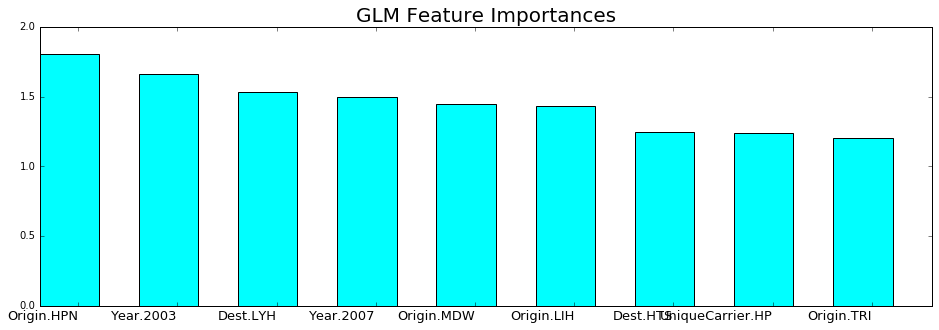

In [109]:
# Plot GLM Feature Importances
all_importances = pandas.DataFrame(glm_sorted)
importances = all_importances[1:10]
feature_labels = list(importances[0])
Index = importances.index

plt.figure(figsize=(16,5))
h = plt.bar(xrange(len(feature_labels)), importances[1],width=0.6, label=feature_labels, color ='aqua')
plt.title("GLM Feature Importances", fontsize=20 )
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, feature_labels, fontsize=13,  ha='right')

In [24]:
# DRF Variable Importance
data_rf2.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,Year,3539.358398,1.000000,0.433376
1,Origin,2047.713135,0.578555,0.250732
2,Dest,1233.663208,0.348556,0.151056
3,UniqueCarrier,716.894470,0.202549,0.087780
4,FlightNum,219.663422,0.062063,0.026897
5,DayOfWeek,208.380493,0.058875,0.025515
6,Distance,197.468750,0.055792,0.024179
7,Month,3.805698,0.001075,0.000466


([<matplotlib.axis.XTick at 0x11835a690>,
 <a list of 8 Text xticklabel objects>)

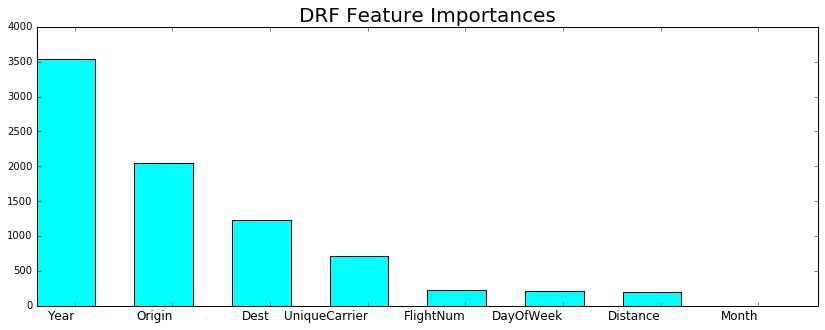

In [113]:
# Plot DRF Feature Importances
importances = data_rf2.varimp(use_pandas=True)
feature_labels = list(importances['variable'])
Index = importances.index

plt.figure(figsize=(14,5))
h = plt.bar(xrange(len(feature_labels)), importances['relative_importance'],width=0.6, label=feature_labels, color ='aqua')
plt.title("DRF Feature Importances", fontsize=20 )
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, feature_labels, fontsize=12,  ha='right')

In [25]:
# GBM Variable Importance
data_gbm2.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,Year,4819.093750,1.000000,0.350955
1,Origin,4730.233398,0.981561,0.344484
2,Dest,3070.144287,0.637079,0.223586
3,UniqueCarrier,439.409058,0.091181,0.032000
4,DayOfWeek,338.982544,0.070342,0.024687
5,FlightNum,216.594635,0.044945,0.015774
6,Distance,116.917862,0.024261,0.008515
7,Month,0.000000,0.000000,0.000000


([<matplotlib.axis.XTick at 0x1176670d0>,
 <a list of 8 Text xticklabel objects>)

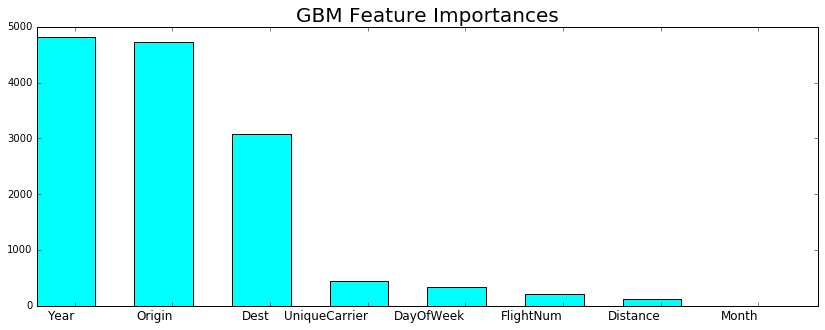

In [114]:
# Plot GBM Feature Importances
importances = data_gbm2.varimp(use_pandas=True)
feature_labels = list(importances['variable'])
Index = importances.index

plt.figure(figsize=(14,5))
h = plt.bar(xrange(len(feature_labels)), importances['relative_importance'],width=0.6, label=feature_labels, color ='aqua')
plt.title("GBM Feature Importances", fontsize=20 )
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, feature_labels, fontsize=12,  ha='right')

In [26]:
# Deep Learning Variable Importance
data_dl.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,Origin.MDW,1.000000,1.000000,0.004851
1,Dest.SAT,0.980114,0.980114,0.004755
2,Dest.EYW,0.963353,0.963353,0.004673
3,UniqueCarrier.HP,0.940622,0.940622,0.004563
4,Year.1992,0.922181,0.922181,0.004474
5,Dest.AMA,0.914540,0.914540,0.004436
6,Dest.BHM,0.913775,0.913775,0.004433
7,Origin.DCA,0.911149,0.911149,0.004420
8,Origin.ABQ,0.909689,0.909689,0.004413
9,Origin.CHS,0.895508,0.895508,0.004344


([<matplotlib.axis.XTick at 0x11915b050>,
 <a list of 9 Text xticklabel objects>)

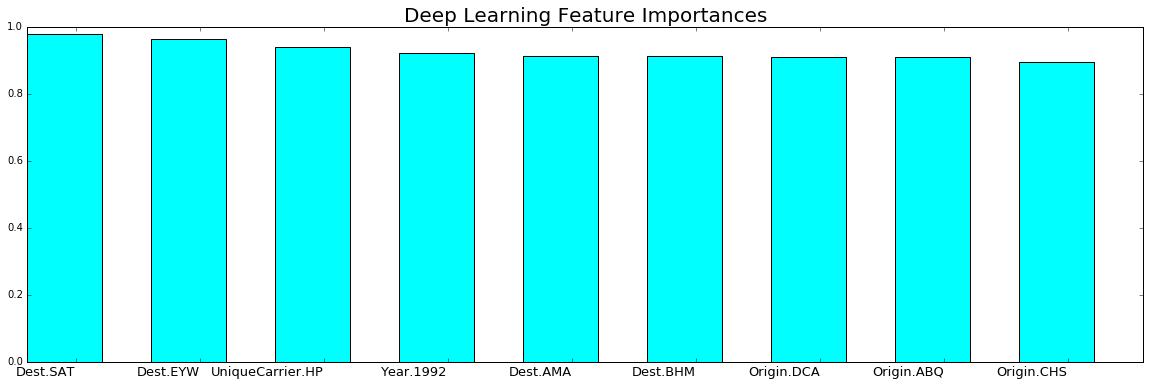

In [115]:
# Plot Deep Learning Feature Importances
all_importances = data_dl.varimp(use_pandas=True)
importances = all_importances[1:10]
feature_labels = list(importances['variable'])
Index = importances.index

plt.figure(figsize=(20,6))
h = plt.bar(xrange(len(feature_labels)), importances['relative_importance'],width=0.6, label=feature_labels, color ='aqua')
plt.title("Deep Learning Feature Importances",fontsize = 20)
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, feature_labels,fontsize = 13,   ha='right')

<a name="question"></a>
# Can H2O Handle New Categorical Levels in a Test Set? 
___
> *Yes! Unlike most machine learning algorithms, H2O-3's algorithms can successfully make predictions, even if a test set contains categorical levels that were not present in the training set. This is because every algorithm replaces new categorical levels with NA values. So, the next question becomes:* 

> __How does each algorithm handle NA values in a test set?__ 

### Skip to the algorithm you're using to see how it predicts on a categorical level not seen during training:<a name="answer"></a>

(Note: NA values in the training set are not handled the same way as NA values in the test set)

* [Generalized Linear Model (GLM)](#GLM)
* [Gradient Boosting Model (GBM) & Distributed Random Forest (DRF)](#GBM & DRF)
* [Deep Learning](#DL)
* [K-Means](#K)
* [Principal Component Analysis (PCA)](#PCA)
* [Naive Bayes](#NB)

___

<a name="GLM"></a>
 ** GLM **:

  GLM will predict 'Double.NAN' for each row with a new categorical level, indicating a prediction wasn't made.
  
  *After running the cells to load, clean, and split the data you can play with a GLM [here](#GLM Model).*

<a name="GBM & DRF"></a>
 ** DRF & GBM ** :

  Both DRF and GBM convert a new categorical level to a NA value in a test set, and then split left on the NA value during scoring. The algorithm splits left on NA values because, during training, NA values are grouped with the outliers in the left-most bin.
  
  *After running the cells to load, clean, and split the data you can play with a GBM [here](#GBM Model) or a DRF [here](#DRF Model).*

<a name="DL"></a>
 ** Deep Learning **:

  For an unseen categorical level in the test set, Deep Learning makes an extra input neuron that remains untrained and contributes some random amount to the subsequent layer.

  *After running the cells to load, clean, and split the data you can play with a Deep Learning model [here](#DL Model).*

<a name="K"></a>
 ** K-Means **: 

  An unseen categorical level in a row does not contribute to that row's prediction. This is because the unseen  categorical level does not contribute to the distance comparison between clusters, and therefore does not factor in  predicting the cluster to which that row belongs.

<a name="NB"></a>
 ** Naive Bayes **:
 
  If the Laplace smoothing parameter is disabled ('laplace = 0'), then Naive Bayes will predict a probability of 0 for any row in the test set that contains a previously unseen categorical level. However, if the Laplace smoothing parameter is used (e.g. 'laplace = 1'), then the model can make predictions for rows that include previously unseen categorical level.
  
  Laplace smoothing adjusts the maximum likelihood estimates by adding 1 to the numerator and k to the denominator to allow for new categorical levels in the training set:

$$\phi_{j|y=1}= \frac{\Sigma_{i=1}^m 1(x_{j}^{(i)} \ = \ 1 \ \bigcap y^{(i)} \ = \ 1) \ + \ 1}{\Sigma_{i=1}^{m}1(y^{(i)} \ = \ 1) \ + \ k}$$

$$\phi_{j|y=0}= \frac{\Sigma_{i=1}^m 1(x_{j}^{(i)} \ = \ 1 \ \bigcap y^{(i)} \ = \ 0) \ + \ 1}{\Sigma_{i \ = \ 1}^{m}1(y^{(i)} \ = \ 0) \ + \ k}$$
   
(Where $x^{(i)}$ represents features, $y^{(i)}$ represents the response column, and $k$ represents the addition of each new categorical level (k functions to balance the added 1 in the numerator))

Laplace smoothing should be used with care; it is generally intended to allow for predictions in rare events. As prediction data becomes increasingly distinct from training data, new models should be trained when possible to account for a broader set of possible feature values.

  *After running the cells to load, clean, and split the data you can play with a Naive Bayes model [here](#NB Model).*

<a name="PCA"></a>
 ** PCA **: 

  New categorical levels in the test data that were not present in the training data, are skipped in the row product-  sum.

<a name="resources"></a>
## Additional Resources
0. [H2O's How To for Basic Questions](http://h2oai.github.io/data-science-examples/examples.html)
1. [H2O's User Guide Documentation](http://h2o-release.s3.amazonaws.com/h2o/rel-tibshirani/8/docs-website/h2o-docs/index.html)
2. [H2O's Algorithm Documentation](https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/datascience/DataScienceH2O-Dev.md)
3. [H2O's Community - Where Questions are Posted](https://groups.google.com/forum/#!forum/h2ostream)
4. [H2O's Python Demos](https://github.com/h2oai/h2o-3/tree/master/h2o-py/demos)
5. [Python to R Parity](https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/upgrade/PythonParity.md)
